In [47]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler, Tokenizer, Word2Vec
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql.functions import isnan, when, count, col, UserDefinedFunction as udf
from pyspark.sql.types import IntegerType

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [10]:
jsonpath = 'Digital_Music_5.json'
appname = 'Amazon Music Reviews'
sparkurl = 'local[*]'
randomseed = 141107
trainingratio = .8


In [11]:
spark = SparkSession.builder.appName(appname).master(sparkurl).getOrCreate()
sqlcontext = SQLContext(spark)

In [13]:
am = sqlcontext.read.json(jsonpath)

In [14]:
print(len(am.columns))

9


In [16]:
am.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [17]:
am.head()

Row(asin='5555991584', helpful=[3, 3], overall=5.0, reviewText='It\'s hard to believe "Memory of Trees" came out 11 years ago;it has held up well over the passage of time.It\'s Enya\'s last great album before the New Age/pop of "Amarantine" and "Day without rain." Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song."Memory of Trees" is elegaic&majestic.;"Pax Deorum" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a "disconcerting" blend of spirituality&sensuality;,I don\'t find it disconcerting at all."Anywhere is" is a hopeful song,looking to possibilities."Hope has a place" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I\'ve always had a soft spot for this song."On my way home" is a triumphant ending about return.This is truly a masterpiece of New Age music,a mus

In [18]:
am.dtypes

[('asin', 'string'),
 ('helpful', 'array<bigint>'),
 ('overall', 'double'),
 ('reviewText', 'string'),
 ('reviewTime', 'string'),
 ('reviewerID', 'string'),
 ('reviewerName', 'string'),
 ('summary', 'string'),
 ('unixReviewTime', 'bigint')]

We really only need the reviewtext and the overall score for classification.

In [19]:
am.registerTempTable('reviews')

In [20]:
sql = sqlcontext.sql

In [23]:
sql('''SELECT overall, count(overall) 
       FROM reviews 
       GROUP BY overall 
       ORDER BY overall DESC''').show()

+-------+--------------+
|overall|count(overall)|
+-------+--------------+
|    5.0|         35580|
|    4.0|         16536|
|    3.0|          6789|
|    2.0|          3010|
|    1.0|          2791|
+-------+--------------+



In [25]:
#As a first trial Im going to use ratings of 5 and 4 for positive sentiment and 1-3 for negative sentiment. This is based on my
#own experience reviewing products. I personally see reviews of 1-3 as negative.
func1 = udf(lambda x: 1 if x> 3.0 else -1, IntegerType())
am = am.withColumn('sentiment', func1(am.overall))

In [29]:
am.registerTempTable('reviews')
sql('''SELECT sentiment, count(sentiment)
       FROM reviews
       GROUP BY sentiment
       ''').show(10)

+---------+----------------+
|sentiment|count(sentiment)|
+---------+----------------+
|       -1|           12590|
|        1|           52116|
+---------+----------------+



In [34]:
am[am.sentiment==1].head()

Row(asin='5555991584', helpful=[3, 3], overall=5.0, reviewText='It\'s hard to believe "Memory of Trees" came out 11 years ago;it has held up well over the passage of time.It\'s Enya\'s last great album before the New Age/pop of "Amarantine" and "Day without rain." Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song."Memory of Trees" is elegaic&majestic.;"Pax Deorum" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a "disconcerting" blend of spirituality&sensuality;,I don\'t find it disconcerting at all."Anywhere is" is a hopeful song,looking to possibilities."Hope has a place" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I\'ve always had a soft spot for this song."On my way home" is a triumphant ending about return.This is truly a masterpiece of New Age music,a mus

In [38]:
amp = am.toPandas()

In [39]:
amp.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,sentiment
0,5555991584,"[3, 3]",5.0,"It's hard to believe ""Memory of Trees"" came ou...","09 12, 2006",A3EBHHCZO6V2A4,"Amaranth ""music fan""",Enya's last great album,1158019200,1
1,5555991584,"[0, 0]",5.0,"A clasically-styled and introverted album, Mem...","06 3, 2001",AZPWAXJG9OJXV,bethtexas,Enya at her most elegant,991526400,1
2,5555991584,"[2, 2]",5.0,I never thought Enya would reach the sublime h...,"07 14, 2003",A38IRL0X2T4DPF,bob turnley,The best so far,1058140800,1
3,5555991584,"[1, 1]",5.0,This is the third review of an irish album I w...,"05 3, 2000",A22IK3I6U76GX0,Calle,Ireland produces good music.,957312000,1
4,5555991584,"[1, 1]",4.0,"Enya, despite being a successful recording art...","01 17, 2008",A1AISPOIIHTHXX,"Cloud ""...""",4.5; music to dream to,1200528000,1


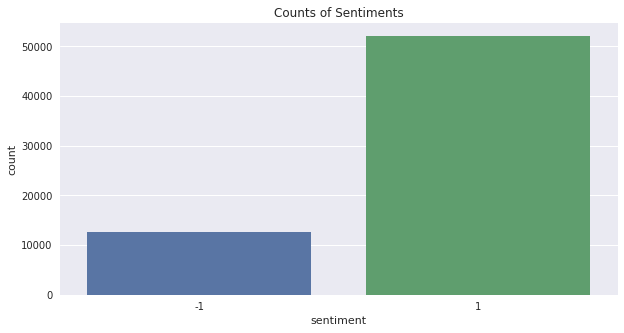

In [44]:
plt.figure(figsize=(10,5))
sns.countplot(amp.sentiment)
plt.title('Counts of Sentiments')
plt.show()

In [56]:
am.select('reviewText', 'summary', 'sentiment').show(5)

+--------------------+--------------------+---------+
|          reviewText|             summary|sentiment|
+--------------------+--------------------+---------+
|It's hard to beli...|Enya's last great...|        1|
|A clasically-styl...|Enya at her most ...|        1|
|I never thought E...|     The best so far|        1|
|This is the third...|Ireland produces ...|        1|
|Enya, despite bei...|4.5; music to dre...|        1|
+--------------------+--------------------+---------+
only showing top 5 rows



In [67]:
tokenizer = Tokenizer(inputCol='reviewText', outputCol='tokenizedreview').transform(am)
tokenizer.select('tokenizedreview').show(1)

+--------------------+
|     tokenizedreview|
+--------------------+
|[it's, hard, to, ...|
+--------------------+
only showing top 1 row



In [70]:
wv = Word2Vec(inputCol='tokenizedreview', outputCol='vector')
wvfit = wv.fit(tokenizer)

In [76]:
wvdf = wvfit.transform(tokenizer)

In [77]:
wvdf.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- sentiment: integer (nullable = true)
 |-- tokenizedreview: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- vector: vector (nullable = true)



In [78]:
wvdf.select('sentiment', 'tokenizedreview', 'vector').show(5)

+---------+--------------------+--------------------+
|sentiment|     tokenizedreview|              vector|
+---------+--------------------+--------------------+
|        1|[it's, hard, to, ...|[-0.0448001732352...|
|        1|[a, clasically-st...|[-0.0655639169198...|
|        1|[i, never, though...|[-0.0662270811084...|
|        1|[this, is, the, t...|[-0.1078565309834...|
|        1|[enya,, despite, ...|[-0.0436644418815...|
+---------+--------------------+--------------------+
only showing top 5 rows



In [79]:
labelindexer = StringIndexer(inputCol='sentiment', outputCol='indexedlabel').fit(wvdf)
vectorindexer = VectorIndexer(inputCol='vector', outputCol='indexedvector').fit(wvdf)
(train, test) = wvdf.randomSplit([.7,.3])
rfc = RandomForestClassifier(labelCol='indexedlabel', featuresCol='indexedvector', numTrees=10)

pipe = Pipeline(stages=[labelindexer, vectorindexer, rfc])

In [81]:
rfcmodel = pipe.fit(train)
predrfc = rfcmodel.transform(test)

In [84]:
evaluator = MulticlassClassificationEvaluator(labelCol='indexedlabel', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predrfc)

print(accuracy)

0.8055612453912331
